<a href="https://colab.research.google.com/github/rinongal/stylegan-nada/blob/StyleGAN3-NADA/stylegan3_nada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# StyleGAN3-NADA - The Official Unofficial Notebook

In [2]:
!wget -q https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl -O content/models/stylegan3-r-ffhq-1024x1024.pkl

In [2]:
import os
from argparse import Namespace

import sys
import numpy as np

from PIL import Image

import torch
import copy
import pickle
from tqdm import notebook

sys.path.insert(0, 'ZSSGAN')
from ZSSGAN.model.ZSSGAN import ZSSGAN
from ZSSGAN.utils.file_utils import save_images, get_dir_img_list
from ZSSGAN.utils.training_utils import mixing_noise

from IPython.display import display

## Setup

In [3]:
source_class = "Photo"
target_class = "rendered 3d in the style of Pixar"
seed = 4

model_path = 'content/models/stylegan3-r-ffhq-1024x1024.pkl'
device = 'cuda'

torch.manual_seed(seed)
np.random.seed(seed)

style_image_dir = ""
target_img_list = get_dir_img_list(style_image_dir) if style_image_dir else None

CLIP_model = "ViT-B/32 + ViT-B/16"
model_choice = ["ViT-B/32", "ViT-B/16"]
model_weights = [0.0, 0.0]

if "ViT-B/32" in CLIP_model:
    model_weights[0] = 1.0
if "ViT-B/16" in CLIP_model:
    model_weights[1] = 1.0

training_iterations = 401 # 601 ~ 801
output_interval     = 50
save_interval       = 0

training_args = {
    "size": 1024,
    "batch": 2,
    "n_sample": 4,
    "output_dir": f'content/output/{source_class}_{target_class}',
    "lr": 0.002,
    "frozen_gen_ckpt": model_path,
    "train_gen_ckpt": model_path,
    "iter": training_iterations,
    "source_class": source_class,
    "target_class": target_class,
    "lambda_direction": 1.0,
    "lambda_patch": 0.0,
    "lambda_global": 0.0,
    "lambda_texture": 0.0,
    "lambda_manifold": 0.0,
    "auto_layer_k": 0,
    "auto_layer_iters": 0,
    "auto_layer_batch": 8,
    "output_interval": 50,
    "clip_models": model_choice,
    "clip_model_weights": model_weights,
    "mixing": 0.0,
    "phase": None,
    "sample_truncation": 0.7,
    "save_interval": save_interval,
    "target_img_list": target_img_list,
    "img2img_batch": 16,
    "sg3": True,
}

args = Namespace(**training_args)

print("Loading base models...")
net = ZSSGAN(args)
print("Models loaded!")

Loading base models...
Models loaded!


In [4]:
g_reg_ratio = 4 / 5

g_optim = torch.optim.Adam(
    net.generator_trainable.parameters(),
    lr=args.lr * g_reg_ratio,
    betas=(0 ** g_reg_ratio, 0.99 ** g_reg_ratio),
)

sample_dir = os.path.join(args.output_dir, "sample")
ckpt_dir   = os.path.join(args.output_dir, "checkpoint")

os.makedirs(sample_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)

## Train

  0%|          | 0/401 [00:00<?, ?it/s]

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


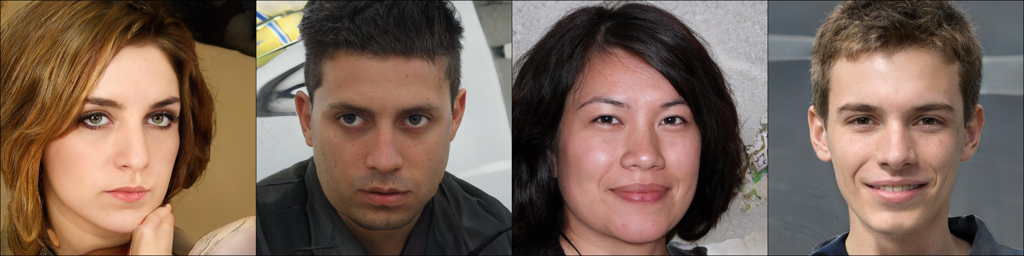

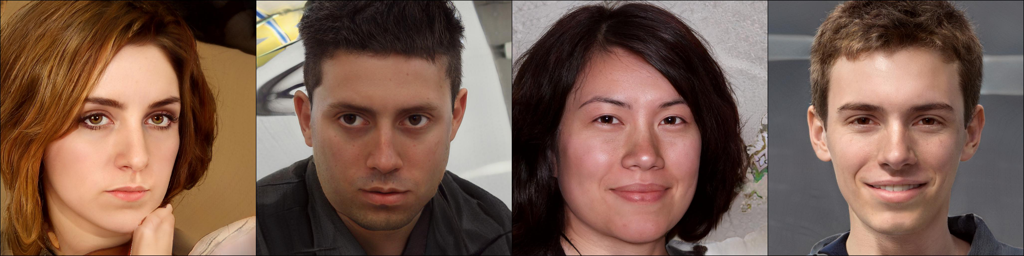

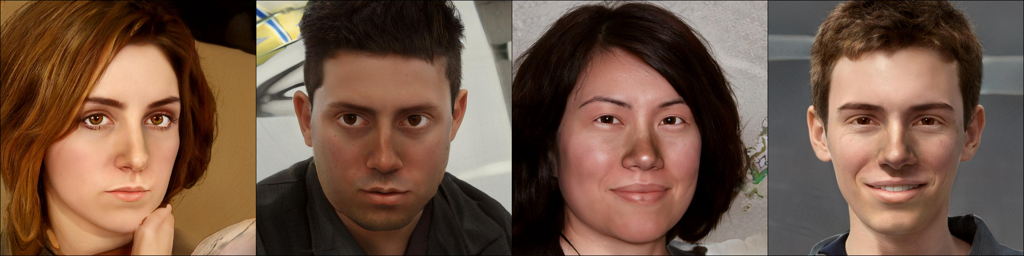

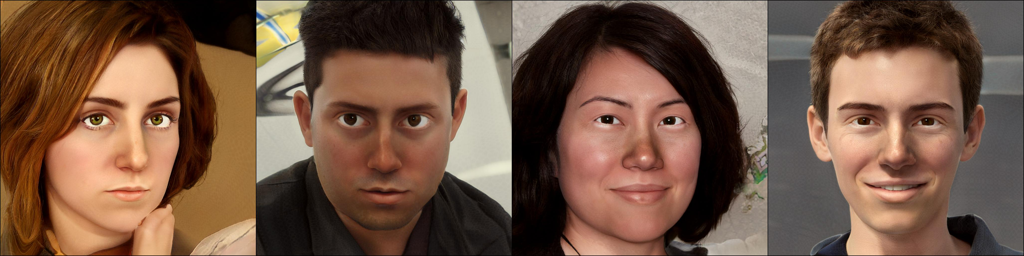

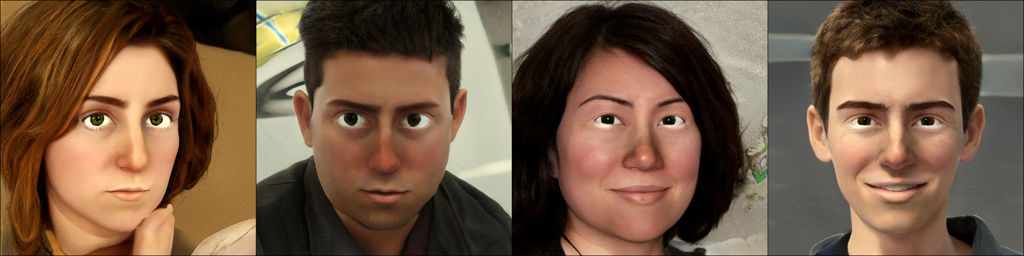

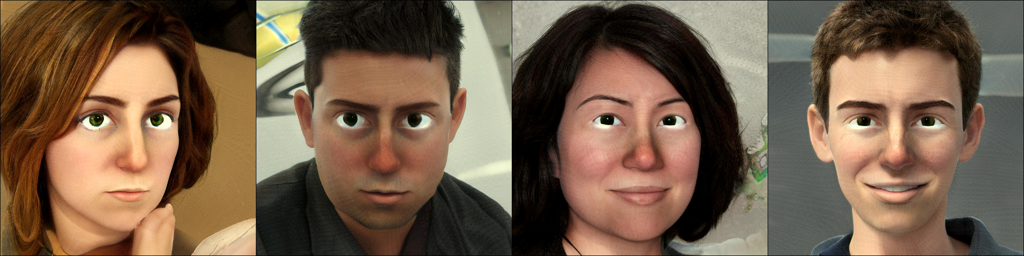

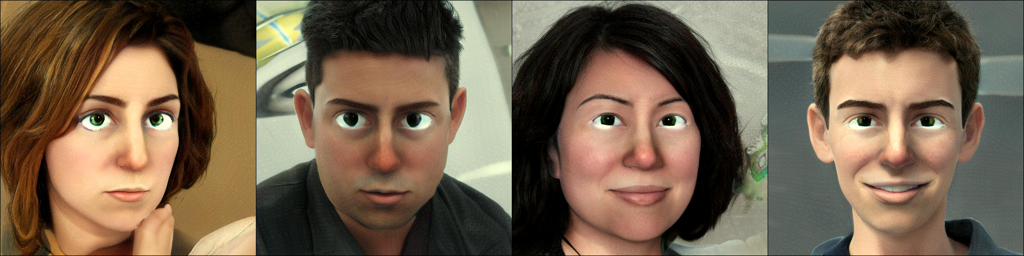

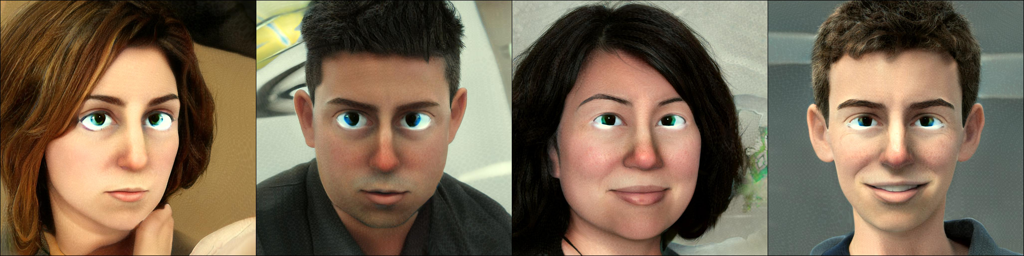

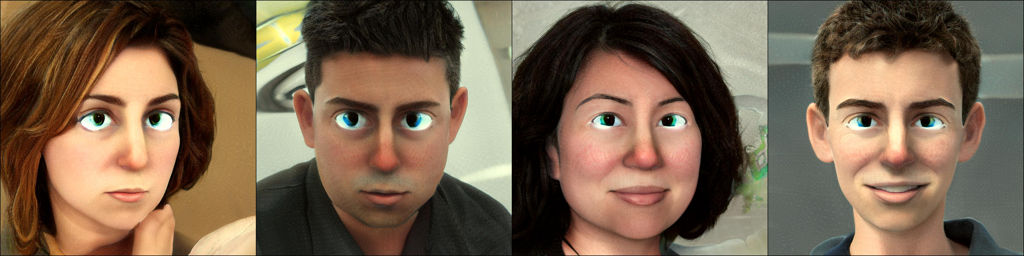

In [5]:
fixed_z = torch.randn(args.n_sample, 512, device=device)

pbar = notebook.tqdm(range(args.iter))
for i in pbar:
    net.train()

    sample_z = mixing_noise(args.batch, 512, args.mixing, device)

    [sampled_src, sampled_dst], clip_loss = net(sample_z)

    net.zero_grad()
    clip_loss.backward()
    g_optim.step()

    pbar.set_description(f'Clip loss: {clip_loss:.6f}')

    if i % output_interval == 0:
        net.eval()

        with torch.no_grad():
            [sampled_src, sampled_dst], loss = net([fixed_z], truncation=args.sample_truncation)

            save_images(sampled_dst, sample_dir, "dst", 4, i)

            img = Image.open(os.path.join(sample_dir, f"dst_{str(i).zfill(6)}.jpg")).resize((1024, 256))
            display(img)
    
    if (args.save_interval > 0) and (i > 0) and (i % args.save_interval == 0):
        snapshot_data = {'G_ema': copy.deepcopy(net.generator_trainable.generator).eval().requires_grad_(False).cpu()}
        snapshot_pkl = f'{ckpt_dir}/{str(i).zfill(6)}.pkl'

        with open(snapshot_pkl, 'wb') as f:
            pickle.dump(snapshot_data, f)

## Generate samples with the new model

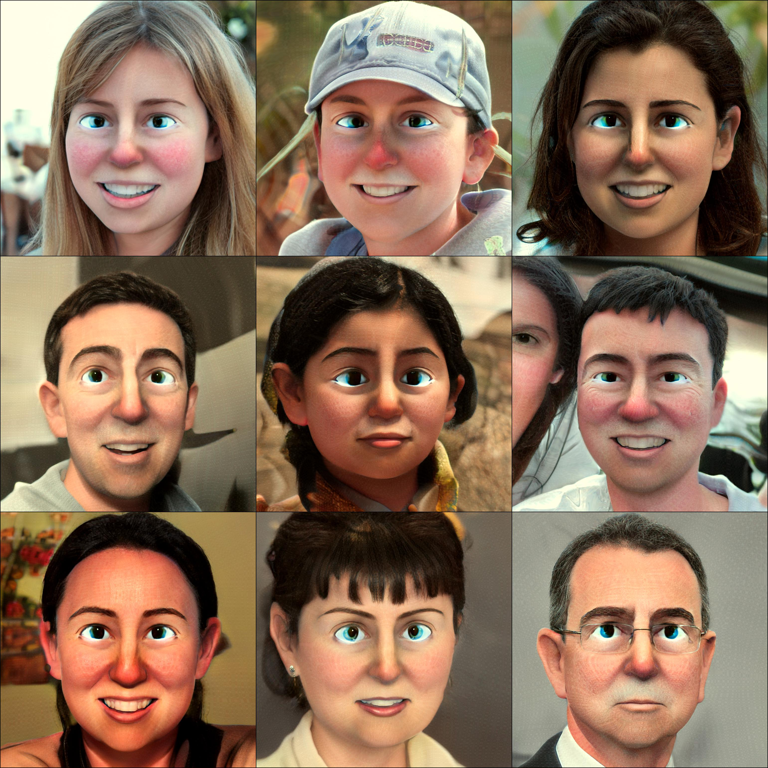

In [6]:
truncation = 0.7
samples = 9

with torch.no_grad():
    net.eval()
    sample_z = torch.randn(samples, 512, device=device)

    [sampled_src, sampled_dst], loss = net([sample_z], truncation=truncation)

    grid_rows = int(samples ** 0.5)

    save_images(sampled_dst, sample_dir, "sampled", grid_rows, 0)
    display(Image.open(os.path.join(sample_dir, f"sampled_{str(0).zfill(6)}.jpg")).resize((768, 768)))

## Save the trained model

In [7]:
snapshot_data = {'G_ema': copy.deepcopy(net.generator_trainable.generator).eval().requires_grad_(False).cpu()}

with open(os.path.join(ckpt_dir, f'{source_class}_{target_class}.pkl'), 'wb') as f:
    pickle.dump(snapshot_data, f)